## Collatz lambda notebook

In [35]:
"""
This notebook analyses the binary growth of a Collatz sequence, denoted by lambda.
"""

# Fix possible import problems
import sys
sys.path.append("..")

# Imports
from math import log2
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd
from collatz import commons


# Configuration
MAX_VALUE = 101
K_FACTOR = 3
MAX_ITERATIONS = 50
PRINT_TABLE = True

START_VALUE = rnd.randint(1, MAX_VALUE)

if START_VALUE % 2 == 0:
    START_VALUE = START_VALUE + 1

# START_VALUE = 3973

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.expand_frame_repr', False)

# Generate a collatz components
analysis_frame = commons.odd_collatz_sequence_components(
    START_VALUE, K_FACTOR, MAX_ITERATIONS)

# Derive new fields
analysis_frame["k**n_log2"] = log2(K_FACTOR) * analysis_frame["n"]
analysis_frame["alpha_i"] = analysis_frame["decimal"].apply(commons.trailing_zeros)
analysis_frame["alpha_i"] = analysis_frame["alpha_i"].astype('int64')
analysis_frame["alpha"] = analysis_frame["alpha_i"].cumsum()
analysis_frame["alpha_max"] = \
    log2(START_VALUE) + (analysis_frame["n"] * log2(K_FACTOR))
analysis_frame["alpha_max"] = analysis_frame["alpha_max"].astype('int64') + 1

analysis_frame["log2"] = analysis_frame["decimal"].apply(log2)
analysis_frame["bin_str"] = analysis_frame["decimal"].apply(commons.to_binary)
analysis_frame["bin_len"] = analysis_frame["log2"].astype('int64') + 1
analysis_frame["lambda_hyp"] = (analysis_frame["n"] * log2(K_FACTOR))
analysis_frame["lambda_max"] = analysis_frame["lambda_hyp"].astype('int64') + 1

prev_bin_len = list(analysis_frame[:-1]["bin_len"])
prev_bin_len.insert(0, prev_bin_len[0])
analysis_frame["bin_diff"] = analysis_frame["bin_len"] - pd.Series(prev_bin_len)

analysis_frame["lambda_i"] = analysis_frame["bin_diff"]
analysis_frame.loc[analysis_frame["lambda_i"] < 0, "lambda_i"] = 0
analysis_frame["lambda"] = analysis_frame["lambda_i"].cumsum()

next_decimal = list(analysis_frame[1:]["decimal"])
next_decimal.append(0)
analysis_frame["next_decimal"] = next_decimal

# Remove final result
analysis_frame = analysis_frame[:-1]

# Validate lambda
l_max_valid = int((analysis_frame["lambda"] > analysis_frame["lambda_max"]).sum()) < 1

# Print results
print_frame = analysis_frame[[
    "n", "variable", "decimal", "next_decimal",
    "log2", "k**n_log2", "bin_str", "bin_len",
    "lambda_i", "lambda", "lambda_max",
    "alpha", "alpha_max"
]]

print_frame.columns = [
    "n","var", "dec", "next", 
    "log2", "k**n_log2", "b_str", "b_len",
    "l_i", "l", "l_max",
    "a", "a_max"
]

print("Start value:", START_VALUE, 
      " K:", K_FACTOR, 
      " Lambda max valid:", l_max_valid,
      "\n")

if PRINT_TABLE:
    print(print_frame.to_string(), "\n")

Start value: 15  K: 3  Lambda max valid: False 

    n     var  dec  next      log2  k**n_log2     b_str  b_len  l_i  l  l_max   a  a_max
0   1     v_i   15    45  3.906891   1.584963      1111      4    0  0      2   0      6
1   1    kv_i   45    46  5.491853   1.584963    101101      6    2  2      2   0      6
2   1  kv_i+1   46    23  5.523562   1.584963    101110      6    0  2      2   1      6
3   2     v_i   23    69  4.523562   3.169925     10111      5    0  2      4   1      8
4   2    kv_i   69    70  6.108524   3.169925   1000101      7    2  4      4   1      8
5   2  kv_i+1   70    35  6.129283   3.169925   1000110      7    0  4      4   2      8
6   3     v_i   35   105  5.129283   4.754888    100011      6    0  4      5   2      9
7   3    kv_i  105   106  6.714246   4.754888   1101001      7    1  5      5   2      9
8   3  kv_i+1  106    53  6.727920   4.754888   1101010      7    0  5      5   3      9
9   4     v_i   53   159  5.727920   6.339850    110101      

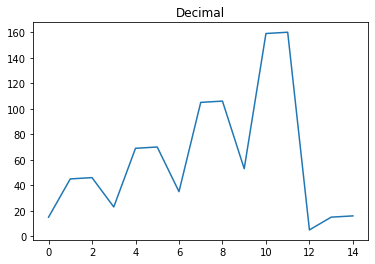

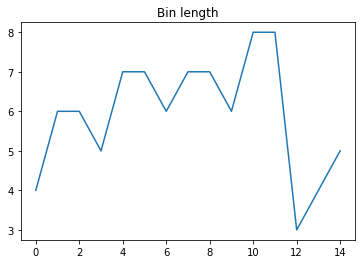

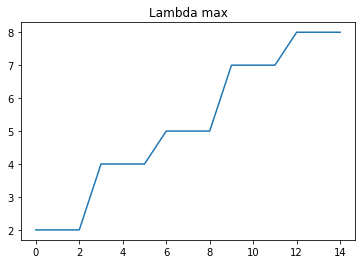

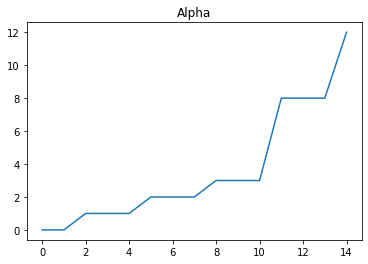

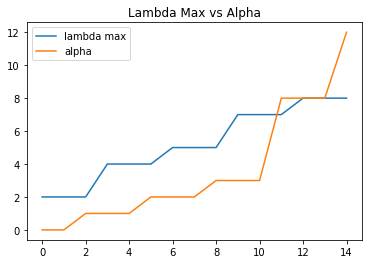

In [36]:
#Plot results
# Decimal
plt.figure()
plt.title("Decimal")
plt.plot(analysis_frame["decimal"], "-")

# Bin len
plt.figure()
plt.title("Bin length")
plt.plot(analysis_frame["bin_len"], "-")

plt.figure()
plt.title("Lambda max")
plt.plot(analysis_frame["lambda_max"], "-")

plt.figure()
plt.title("Alpha")
plt.plot(analysis_frame["alpha"], "-")

plt.figure()
plt.title("Lambda Max vs Alpha")
plt.plot(analysis_frame["lambda_max"], label="lambda max")
plt.plot(analysis_frame["alpha"], label="alpha")
plt.legend()

plt.show()